# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import solve
from scipy.integrate import odeint
import imageio
from tqdm import tqdm
import plotly_express as px
import pandas as pd
from scipy.interpolate import make_interp_spline
import time as TIME

from bokeh.plotting import figure, show
import bokeh.io
import bokeh.plotting
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
from bokeh.palettes import Viridis, Spectral, Bokeh, Cividis, Category10
bokeh.io.output_notebook()

import warnings
warnings.filterwarnings("ignore")

ERROR! Session/line number was not unique in database. History logging moved to new session 2306


Loading BokehJS ...

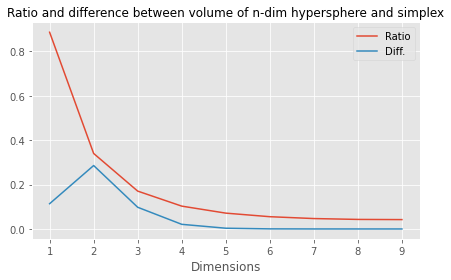

In [2]:
from math import factorial
from scipy.special import gamma
n = 5
pi= np.pi

ratio = []
V_pyr, V_sph = [],[]

for n in range(1,10):
    h_pyr = np.sqrt((n+1)/(2*n))

    V_pyr.append(np.sqrt(n+1)/(factorial(n)*np.sqrt(2**n)))
    V_sph.append((np.sqrt(pi)**2 * (h_pyr/4)**n) /gamma(n/2+1))
    ratio.append(V_sph[-1]/V_pyr[-1])

with plt.style.context("ggplot"):
    plt.plot(np.arange(1,10),ratio, label="Ratio")
    plt.plot(np.arange(1,10),np.array(V_pyr)-np.array(V_sph), label="Diff.")
    plt.xticks(np.arange(1,10))
    #plt.grid(linestyle="--")
    plt.xlabel("Dimensions")
    plt.legend()
    plt.title("Ratio and difference between volume of n-dim hypersphere and simplex", fontsize=12)
    plt.tight_layout()
    plt.show()


# Definition of problem's parameters

In this section I defined the a function which splits an interval of a given lenght in *dim* subintervals. The sum of all this subintervals always gives the initial chosen lenght. This is used to generate the $\alpha$ (metabolic strategies), $\vec{n_0}$ (initial value of the population aboundances), and the $\vec{s}$ (supply rates)

Additionally some important constants are defined. A high relavance is for the $\delta$ parametr value, which I don't really understood why has to be $\frac{1}{3}$ an not a inch more.

In [3]:
def SupplyRateGen(dim, E):
    """ Returns a set of ranodom values that sums up to E
        dim = # of elements to return
        E = sum of the dim elements (metabolic constraint)
    """
    return np.array(np.ediff1d(np.sort(np.hstack((0,np.random.uniform(0,E,dim-1), E)))))

n_pop=10                #number of polulations in the system
n_res=3                 #number of resources in the system
Energy=1                #metabolic constraint
L=1                     #lenght of the territory / maximum cumulative value of the population's abundance
D=0.1                   #parameters that regulates the spatial mixing of the nutrient in the system
S_tot=1                 #norm of the supply vector
S=[0.2,0.4,0.4]         #supply vector
delta=1/3               #death rate = 1/n_res
v=1                     #resource convertion rate

# Metabolic Strategies 3D plot

In [4]:
#generate n_pop=10 alpha vectors, each of n_res=3 elements

np.random.seed(3) #for the reproducibility

alpha=[]
for i in range(n_pop):
    alpha.append(SupplyRateGen(n_res, Energy))

In [5]:
def f(x, y, Energy):
    return Energy-x-y

def plot_triangle(ax, Energy_tri):
    """ Draws the traingle in the 3-d space s.t. sum(alpha)=Energy_tri
    """

    x=np.linspace(0,Energy_tri,30)
    y=np.linspace(0,Energy_tri,30)

    trian=[]
    for i in range(10000): #function used to generate the traingle s.t. x+y+z=Energy_ol
        point=np.random.rand(2)*Energy_tri
        if sum(point)<Energy_tri:
            trian.append(point)
    trian=np.array(trian)

    ax.plot3D(trian[:,0] ,trian[:,1], f(trian[:,0], trian[:,1], Energy_tri),alpha=0.2, color="gray") #triangle area
    ax.plot3D(x           ,np.zeros(30)     ,f(x,np.zeros(30), Energy_tri), color="k") #triangle borders
    ax.plot3D(x,f(x, np.zeros(30), Energy_tri),np.zeros(30)          , color="k")
    ax.plot3D(np.zeros(30),x                ,f(np.zeros(30),x, Energy_tri), color="k")



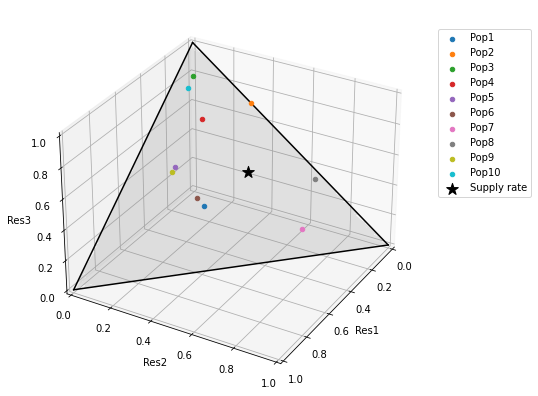

In [28]:
np.random.seed(1) #for the reproducibility

alpha=[]
for i in range(n_pop):
    alpha.append(SupplyRateGen(n_res, Energy))

plt.figure(figsize=(7,7))
ax = plt.axes(projection="3d")

for i in range(len(alpha)):
    ax.scatter3D(alpha[i][0],alpha[i][1],alpha[i][2], label="Pop"+str(i+1)) #metabolic strategie points

plot_triangle(ax, Energy)

ax.scatter(Energy/S_tot*S[0],Energy/S_tot*S[1],Energy/S_tot*S[2], color="k", marker="*", s=150, label="Supply rate") #Point defined by the supply rate

ax.azim=30 #change the orientation of the graph
ax.set_xlabel("Res1")
ax.set_ylabel("Res2")
ax.set_zlabel("Res3")

ax.set_xlim(0,Energy)
ax.set_ylim(0,Energy)
ax.set_zlim(0,Energy)
plt.legend(loc=(1.05,0.5))
plt.show()

In [29]:
alpha_data = pd.DataFrame([*alpha])
alpha_data["pop"] = pd.Series(["Pop"+str(i) for i in np.arange(1,11)])
alpha_data.columns=["Res1","Res2","Res3","Population"]
alpha_data

,Res1,Res2,Res3,Population
0,0.417022,0.303302,0.279676,Pop1
1,0.000114,0.302218,0.697667,Pop2
2,0.092339,0.054417,0.853244,Pop3
3,0.186260,0.159301,0.654439,Pop4
4,0.396767,0.142049,0.461183,Pop5
5,0.419195,0.266025,0.314780,Pop6
6,0.204452,0.673665,0.121883,Pop7
7,0.027388,0.643080,0.329532,Pop8
8,0.417305,0.141385,0.441310,Pop9
9,0.140387,0.057715,0.801899,Pop10


In [30]:
S_df= pd.DataFrame(np.concatenate([S, ["Supply rate"]], axis=0)).T
S_df.columns=["Res1","Res2","Res3","Population"]
S_df

,Res1,Res2,Res3,Population
0,2e-01,0.4,0.4,Supply rate


In [31]:
triang_px = px.scatter_ternary(alpha_data, a="Res1", b="Res2", c="Res3", color="Population", 
                                color_discrete_sequence=px.colors.qualitative.D3, width=800)



triang_px.add_scatterternary(a=[S[0]], b=[S[1]], c=[S[2]], mode='markers', name="Supply vector",
                            marker_symbol='star', marker_color='black', marker_size=10)
triang_px.update_layout(xaxis_title="ciao")
triang_px.show()

With this function we look for the values $A_{\sigma,i}, B_{\sigma,i}$, the parameters which have to be tuned in order to obtain the continuity of every resource aboundance function and also the continuity of its derivative. This is obtained by using the `solve` function from `scipy.linalg`, which allows to solve easily a linear system of equation. The intial condition are imposed and inserted into the *coeff_matr* and *const_matr* matrices, and the values are found. 

In [32]:
def ResParams(pop,res,alpha_par,S_par,Di):
    n_pop=len(pop)
    
    coeff_matr=np.zeros((n_pop*2, n_pop*2))
    const_matr=np.zeros(n_pop*2)
    for s in range(n_pop):

        if s==0:
            s_eff=s+n_pop
        else:
            s_eff=s  

        coeff_matr[2*s][s]=1 
        coeff_matr[2*s][s+n_pop]=1 
        coeff_matr[2*s][s_eff-1]=-np.exp(pop[s_eff-1]*np.sqrt(alpha_par[s_eff-1][res]/Di))
        coeff_matr[2*s][s_eff+n_pop-1]=-np.exp(-pop[s_eff-1]*np.sqrt(alpha_par[s_eff-1][res]/Di))

        coeff_matr[(2*s)+1][s]=np.sqrt(alpha_par[s][res]/Di)
        coeff_matr[(2*s)+1][s+n_pop]=-np.sqrt(alpha_par[s][res]/Di)
        coeff_matr[(2*s)+1][s_eff-1]=-np.sqrt(alpha_par[s_eff-1][res]/Di)*np.exp(pop[s_eff-1]*np.sqrt(alpha_par[s_eff-1][res]/Di))
        coeff_matr[(2*s)+1][s_eff+n_pop-1]=np.sqrt(alpha_par[s_eff-1][res]/Di)*np.exp(-pop[s_eff-1]*np.sqrt(alpha_par[s_eff-1][res]/Di))

        const_matr[2*s]=(S_par[res]/alpha_par[s_eff-1][res])-(S_par[res]/alpha_par[s][res])

    sol=solve(coeff_matr, const_matr)

    return sol, coeff_matr, const_matr

Funciton for the spatial dynamics of the resources

In [33]:
def cres(x,s,i,A,B,alpha_cres,S_i,D_cres):
    if isinstance(x, (int, float)):
        return A*np.exp(x*np.sqrt(alpha_cres[s][i]/D_cres))+B*np.exp(-x*np.sqrt(alpha_cres[s][i]/D_cres))+(S_i[i]/alpha_cres[s][i])
    else:
        return [A*np.exp(xi*np.sqrt(alpha_cres[s][i]/D_cres))+B*np.exp(-xi*np.sqrt(alpha_cres[s][i]/D_cres))+(S_i[i]/alpha_cres[s][i]) for xi in x]

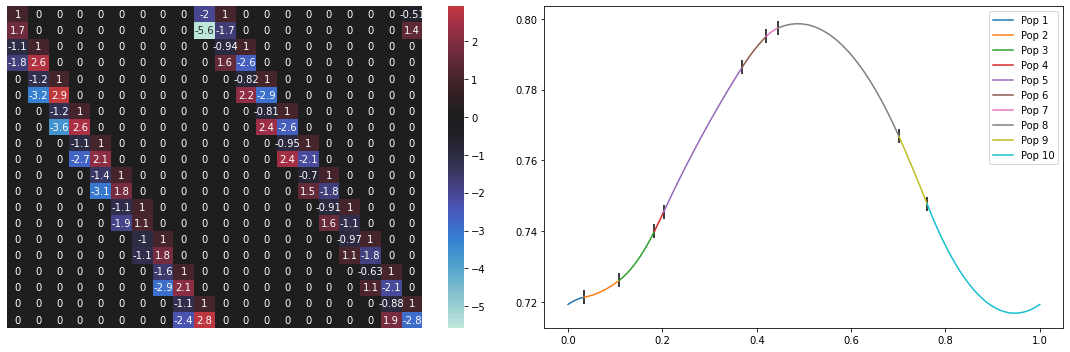

In [34]:
_, sx = plt.subplots(1,2, figsize=(15,5))

n0=SupplyRateGen(n_pop,L)
sol_all=[]

for j in range(n_res):
    sol, coeff_matr, const_matr = ResParams(n0, j, alpha, S, D)
    sol_all.append(sol)

res=2
sns.heatmap(coeff_matr, annot=True, ax=sx[0], center=0)
sx[0].set_xticks([])
sx[0].set_yticks([])
for p in range(n_pop):
    time=np.linspace(0,n0[p],1000)
    if p==0:
        y_res = cres(time, p,res,sol_all[res][p], sol_all[res][n_pop+p], alpha, S, D)
        sx[1].plot(time, y_res, label="Pop 1")
        sx[1].vlines(time[-1], y_res[-1]-0.002, y_res[-1]+0.002, color="k")
    else:
        x_res = time+np.cumsum(n0)[p-1]
        y_res = cres(time, p,res,sol_all[res][p], sol_all[res][n_pop+p], alpha, S, D)
        sx[1].plot(x_res, y_res, label=f"Pop {p+1}")
        if p!= n_pop-1 : sx[1].vlines(x_res[-1], y_res[-1]-0.002, y_res[-1]+0.002, color="k")


sx[1].legend()
plt.tight_layout()
plt.show()

The heatmap represents the coefficient of the linear system used to find $A_{\sigma,i}, B_{\sigma,i}$, while the graph on the left represent the result of the computation of a resource distribution over the space occupied by each population. As we can see bothe the function and its derivative are continous.

Function that computes the value of the integral $\int_0^{n_{\sigma}}{c_i(x)}dx$, solved analytically.

In [35]:
def my_integr(s,i, ni, alpha_int,S_int, sol_all_int,Di):
    cc = ni[s]*S_int[i]/alpha_int[s][i]
    aa = sol_all_int[i][s]*np.sqrt(Di/alpha_int[s][i])*(np.exp(ni[s]*np.sqrt(alpha_int[s][i]/Di))-1)
    bb = sol_all_int[i][s+n_pop]*np.sqrt(Di/alpha_int[s][i])*(np.exp(-ni[s]*np.sqrt(alpha_int[s][i]/Di))-1)
    return aa-bb+cc

In [36]:
#function that computes the infintesimal increment for each population

def n_incr(s,ni,alpha_incr,S_incr,sol_all_incr,d,v,Di):
    n_res=len(alpha_incr[0])
    incrs = [my_integr(s,i,ni,alpha_incr,S_incr, sol_all_incr,Di)*v*alpha_incr[s][i]-d*ni[s] for i in range(n_res)]
    return np.sum(incrs)

In this cell we can verify if the value of the $\delta$ parameter satisfies the condition $\sum_{\sigma=0}^{n_{pop}} \dot{n}_{\sigma}$

Intersection: 0.333


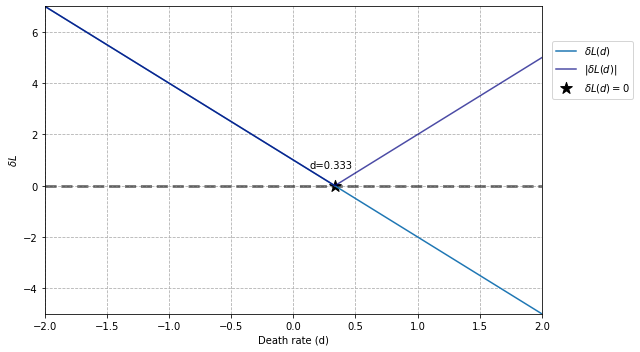

In [37]:
for j in range(n_res):
    sol, coeff_matr, const_matr = ResParams(n0, j, alpha, S,D)
    sol_all.append(sol)


rres=[]
for d in np.linspace(-2,2,10000):
    rres.append(np.sum([n_incr(p,n0,alpha,S,sol_all,d,v,D) for p in range(n_pop)]))

plt.figure(figsize=(9,5))
plt.plot(np.linspace(-2,2,10000),rres, label=r"$\delta L(d)$")
plt.plot(np.linspace(-2,2,10000),np.abs(rres), alpha=0.7, color="navy", label=r"$|\delta L(d)|$")
plt.hlines(0,-2,2, color="k", linestyle="--", lw=3, alpha=0.5)
plt.text(np.linspace(-2,2,10000)[np.argmin(np.abs(rres))]-0.2, 0.7, "d=%.3f" %(np.linspace(-2,2,10000)[np.argmin(np.abs(rres))]))
plt.scatter(np.linspace(-2,2,10000)[np.argmin(np.abs(rres))], 0, marker="*", s=150, color="k", label=r"$\delta L(d)=0$")
plt.grid(linestyle="--")
plt.ylabel(r"$\delta L$")
plt.xlabel("Death rate (d)")
plt.xlim([-2,2])
plt.ylim([min(rres), max(rres)])
plt.legend(loc=[1.02, 0.7])

print("Intersection: %.3f" %(np.linspace(-2,2,10000)[np.argmin(np.abs(rres))]))

plt.tight_layout()
plt.show()

# Functions for complete simulation

Complete generation of $n_{\sigma}$ dynamics for a finite amount of time.

In [38]:
def Simulation(n_iter_sim, dt_sim, n0_sim, n_res_sim, alpha_sim, S_sim, D_sim ,delta_sim, v_sim=1):
    n_sim=[]
    n_sim.append(n0_sim)

    n_pop_sim=len(n0_sim)
    time_sim=np.arange(0,n_iter_sim*dt_sim+dt_sim,dt_sim)

    for t in range(n_iter_sim):
        sol_all_sim=[]
        for j in range(n_res_sim):
            sol, coeff_matr, const_matr = ResParams(n_sim[t], j, alpha_sim, S_sim,D_sim)
            sol_all_sim.append(sol)
        n_sim.append( [ n_sim[t][p]+n_incr(p,n_sim[t],alpha_sim,S_sim,sol_all_sim,delta_sim,v_sim,D_sim)*dt_sim for p in range(n_pop_sim) ] )
    return np.array(n_sim), time_sim

In [39]:
def plot_fill(time_fill,n_fill,fix_bound=True):
    n_pop_fill=len(n_fill[0])
    plt.figure(figsize=(10,5))
    plt.fill_between(time_fill,0, np.cumsum(n_fill,axis=1)[:,0], label=f"Pop{1}")
    for p in range(n_pop_fill-1):
        plt.fill_between(time_fill,np.cumsum(n_fill,axis=1)[:,p],np.cumsum(n_fill,axis=1)[:,p+1], label=f"Pop{p+2}")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
    plt.xlim(0,time_fill[-1])
    if fix_bound:
        plt.ylim(0,1)
    plt.ylabel("Aboundance")
    plt.xlabel("Time")
    plt.tight_layout()

In [40]:
def plot_pie(n_pie):
    n_pop_pie=len(n_pie[0])
    __,axx = plt.subplots(figsize=(10,5))
    axx.pie(n_pie[-1], labels=[f"Pop{i+1}" for i in range(n_pop_pie)],normalize=True, 
            wedgeprops=dict(width=0.3, edgecolor='w'))
    #axx[0].set_title("Initial state", fontweight="bold")
    axx.pie(n_pie[0],normalize=True, wedgeprops=dict(width=0.25, edgecolor='w'), 
            radius=0.75, labeldistance=0.4, labels=[f"Pop{i+1}" for i in range(n_pop_pie)])
    #axx[1].set_title("Final state", fontweight="bold")
    #axx.legend(loc=(1.1,0.5))
    plt.tight_layout()
    plt.show()

In [41]:
def M(ni):
    
    return -np.sum([ni[s]/L*np.log(ni[s]/L) for s in range(len(ni))])

def plot_M(n_m, show=True):
    eff = [M(ni) for ni in n_m]
    if show:
        plt.figure(figsize=(7,4))
        plt.plot(eff, color="forestgreen")
        plt.xlabel("Time")
        plt.ylabel("Effective number of species")
        plt.hlines(0, -len(eff), 2*len(eff), linestyle=":", color="k", lw=2, alpha=0.7)
        plt.xlim(0-0.05*len(eff), len(eff)*1.05)
        plt.grid(axis="x", linestyle=":")
        plt.tight_layout()
        plt.show()

    return eff

# First example

## Population aboundances

In [42]:
n0=SupplyRateGen(n_pop,L)

for i, p in enumerate(n0):
    print("Pop %d initial abundance %.3f" %(i+1, p))


Pop 1 initial abundance 0.034
Pop 2 initial abundance 0.097
Pop 3 initial abundance 0.185
Pop 4 initial abundance 0.002
Pop 5 initial abundance 0.122
Pop 6 initial abundance 0.141
Pop 7 initial abundance 0.101
Pop 8 initial abundance 0.148
Pop 9 initial abundance 0.020
Pop 10 initial abundance 0.150


In [43]:
dt=2
n_iter=int(8000/dt)

n, time = Simulation(n_iter_sim=n_iter,
                     dt_sim=dt,
                     n0_sim=n0,
                     n_res_sim=n_res,
                     alpha_sim=alpha,
                     S_sim=S,
                     D_sim=D,
                     delta_sim=1/n_res,
                     v_sim=1)

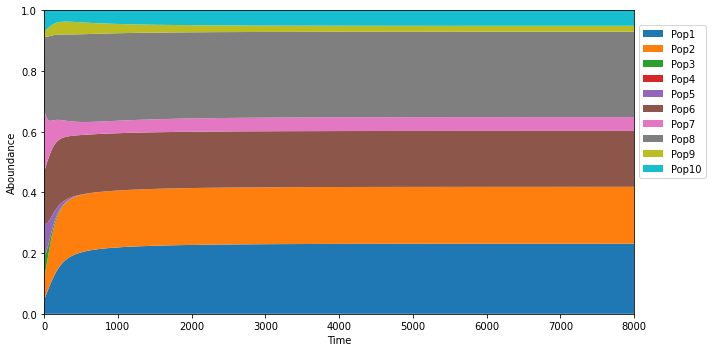

In [44]:
plot_fill(time, n, fix_bound=True)

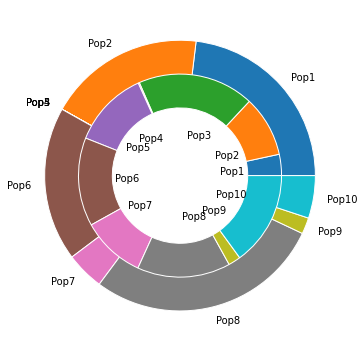

In [45]:
plot_pie(n)

In [46]:
## generation of the GIF for the pie charts

gif=False
if gif:
    count=0
    plt.close()
    for i in tqdm(range(0,len(n), int(len(n)/200))):

        n_pop_pie=len(n[0])
        __,axx = plt.subplots(figsize=(10,5))
        axx.pie(n[i], labels=[f"Pop{i+1}" for i in range(n_pop_pie)],normalize=True, 
                wedgeprops=dict(width=0.3, edgecolor='w'))
        axx.pie(n[0],normalize=True, wedgeprops=dict(width=0.25, edgecolor='w'), 
                radius=0.8, labeldistance=0.4, labels=[f"Pop{i+1}" for i in range(n_pop_pie)])

        plt.savefig(f'ImageGIFFolder/im{count}.png')
        count+=1
        plt.close()

    with imageio.get_writer('mygif.gif', mode='I') as writer:
        for i in range(count):
            image = imageio.imread(f'ImageGIFFolder/im{i}.png')
            writer.append_data(image)
    print("GIF correctly generated")


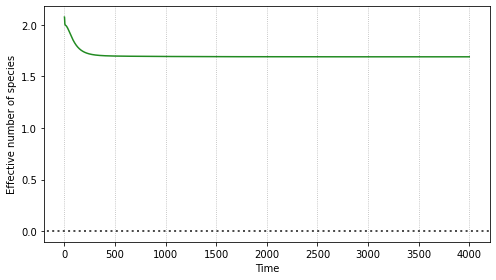

In [47]:
eff=plot_M(n)

## Resource Aboundances

In [48]:
def ResFunc(n,alpha,S,D):
    n_res=len(S)
    n_pop=len(n)
    sol_all=[]

    for j in range(n_res):
        sol, coeff_matr, const_matr = ResParams(n, j,alpha,S,D)
        sol_all.append(sol)
    fin_res=[]
    for i in range(n_res):
        curr_res=[]
        x=[0]
        for p in range(n_pop):
            time=np.linspace(0,n[p],500)
            curr_res= np.hstack((curr_res, cres(time, p,i,sol_all[i][p], sol_all[i][n_pop+p], alpha, S,D)))
            x=np.hstack((x,time+x[-1]))
        fin_res.append([x[1:],curr_res])
    return fin_res

In [49]:
def plot_RES(n_pres, nnres,  alpha_pres, S_pres, D_pres):
    n_pop_pres=len(n_pres[-1])
    plt.figure(figsize=(10,6))
    myres=ResFunc(n_pres[-1],alpha_pres,S_pres,D_pres)
    for r in range(nnres):
        plt.plot(myres[r][0],myres[r][1], label=f"Res{r}", color=plt.get_cmap("Dark2")(r))
    
    limits=np.concatenate(([0],np.cumsum(n_pres[-1])))
    min_res = np.min(np.array(myres)[:,1])
    max_res = np.max(np.array(myres)[:,1])
    plt.vlines(0,-100,100, color="k", linestyles=":")
    for p in range(n_pop_pres):
        plt.vlines(np.cumsum(n_pres[-1])[p],-100,100, color="k", linestyles=":")
        plt.text((limits[p]+limits[p+1])/2,np.min(np.array(myres)[:,1])-(np.max(np.array(myres)[:,1])-np.min(np.array(myres)[:,1]))*0.03,f"{p+1}")
    
    plt.legend()
    plt.xlabel('Population abundance [L]')
    plt.ylabel('Resource aboundance')
    plt.xlim([0,1])
    plt.ylim([min_res-0.05*(max_res-min_res), max_res+0.05*(max_res-min_res)])
    plt.tight_layout()
    plt.show()

### GIF generation

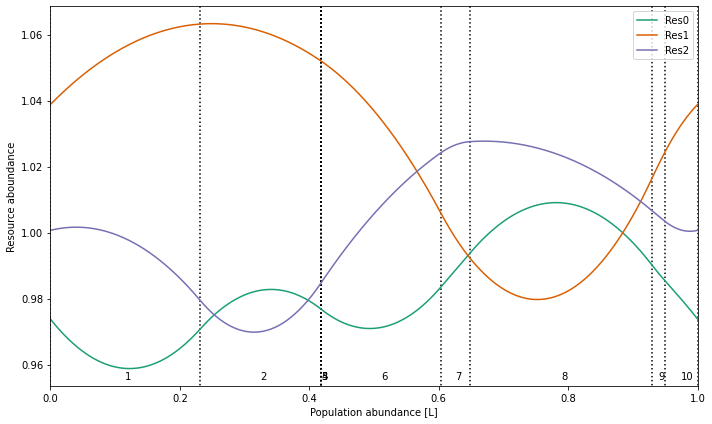

In [50]:
plot_RES(n, n_res, alpha, S, D)

In [51]:
gif=True

if gif:
    count=0
    boundaries=[np.array(ResFunc(n[-1],alpha,S,D))[:,1,:].min(),np.array(ResFunc(n[-1],alpha,S,D))[:,1,:].max()]
    plt.close()
    for i in tqdm(range(0,len(n), int(len(n)/200))):
        myres=ResFunc(n[i],alpha,S,D)
        for r in range(n_res):
            plt.plot(myres[r][0],myres[r][1])
            plt.title(f"Time {dt*i}")

        limits=np.concatenate(([0],np.cumsum(n[-1])))
        plt.vlines(0,np.min(np.array(myres)[:,1]),np.max(np.array(myres)[:,1]), color="k", linestyles=":")
        for p in range(n_pop):
            plt.vlines(np.cumsum(n[i])[p],np.min(np.array(myres)[:,1]),np.max(np.array(myres)[:,1]), color="k", linestyles=":")
            plt.text((limits[p]+limits[p+1])/2,np.min(np.array(myres)[:,1])-(np.max(np.array(myres)[:,1])-np.min(np.array(myres)[:,1]))*0.03,f"{p+1}")
    
        plt.savefig(f'ImageGIFFolder/im{count}.png')
        count+=1
        plt.close()

    with imageio.get_writer('mygif.gif', mode='I') as writer:
        for i in range(count):
            image = imageio.imread(f'ImageGIFFolder/im{i}.png')
            writer.append_data(image)
    print("GIF correctly generated")


100%|██████████| 201/201 [00:31<00:00,  6.48it/s]


GIF correctly generated


# Variation of the Diffusion rate

In [ ]:
np.random.seed(2)

n_Dvar=[]
Ds = np.logspace(-4,8, 13)
for di in Ds:
    print(f"Simulating for D={di}")
    n_provv=[]
    for i in tqdm(range(100)):
        alpha_D=[]
        for i in range(n_pop):
            alpha_D.append(SupplyRateGen(n_res, Energy))
        n_now, __ = Simulation(n_iter_sim=n_iter,
                                dt_sim=dt,
                                n0_sim=n0,
                                n_res_sim=n_res,
                                alpha_sim=alpha_D,
                                S_sim=S,
                                D_sim=di,
                                delta_sim=1/n_res,
                                v_sim=1)
        n_provv.append(n_now[-1])
    n_Dvar.append(n_provv)

n_Dvar=np.array(n_Dvar)

Simulating for D=0.0001


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


Simulating for D=0.001


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


Simulating for D=0.01


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


Simulating for D=0.1


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


Simulating for D=1.0


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


Simulating for D=10.0


100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


Simulating for D=100.0


100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


Simulating for D=1000.0


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Simulating for D=10000.0


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Simulating for D=100000.0


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Simulating for D=1000000.0


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Simulating for D=10000000.0


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Simulating for D=100000000.0


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


In [20]:
#D_df = pd.read_csv("D_df.csv", index_col=0)

In [288]:
M_Dvar = np.array([[M(mdv1) for mdv1 in mdv0] for mdv0 in n_Dvar])

D_df = pd.DataFrame((np.array([[1/di]*100 for di in Ds]).flatten(), M_Dvar.flatten())).T
D_df.columns=[r"\tau_D", "n"]
D_df.head()

,\tau_D,n
0,10000.0,0.024234
1,10000.0,0.922569
2,10000.0,0.862021
3,10000.0,0.559114
4,10000.0,0.264318


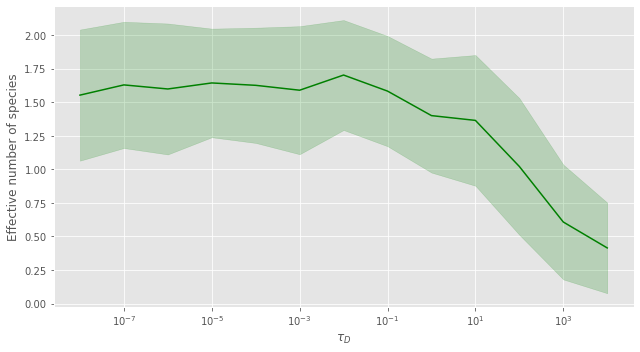

In [22]:
plt.figure(figsize=(9,5))
with plt.style.context("ggplot"):
    D_seab = sns.lineplot(data=D_df, x="\\tau_D", y="n", color="green", err_style="band", ci="sd")
    D_seab.set_xlabel(r"$\tau_D$")
    D_seab.set_ylabel("Effective number of species")
    D_seab.grid(color="white")
    D_seab.set_xscale("log")
plt.tight_layout()

# Well Mixed Model

In [68]:
#funciton for infinitesimal increments

def dn(ni, ntot, alpha_i, alpha_sig, S, d):
    n_res_mix = len(S)
    den = np.array([np.multiply(alpha_i[:,i], ntot).sum() for i in range(n_res_mix)])
    return (np.sum(np.multiply(alpha_sig, np.divide(S, den)))-d)*ni


def dtot(n, t, alpha, d, S):
    return [dn(n[i],n,np.array(alpha), np.array(alpha)[i,:], S, d) for i in range(n_pop)]

In [69]:
dt_mix_3res=0.1
duration_mix_3res=2000
time_mix=np.arange(0,duration_mix_3res+dt_mix_3res,dt_mix_3res)

In [70]:
n_mix_3res = odeint(dtot, n0, time_mix, (alpha,1, S))

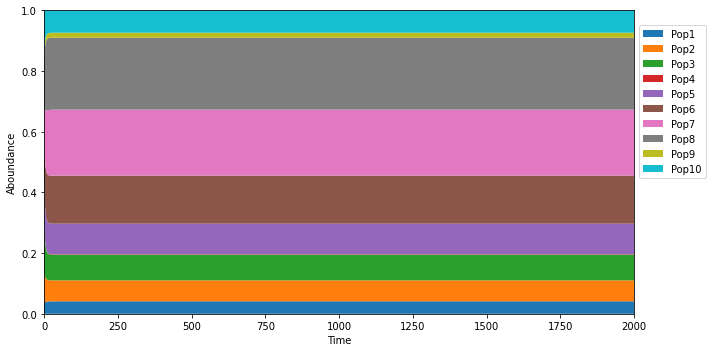

In [71]:
plot_fill(time_mix, n_mix_3res, fix_bound=True)

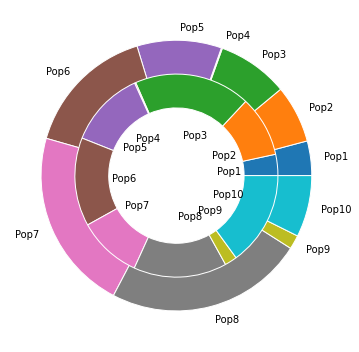

In [72]:
plot_pie(n_mix_3res)

# Spatial 2 resources

In [52]:
np.random.seed(1)

n_res_np = 2
S_np = SupplyRateGen(n_res_np, S_tot)
E_np = 1

In [53]:
def two_res_init(seed, dE, E_np=1):
    np.random.seed(seed)

    alpha_p=[]

    Energy_np = np.random.normal(0, dE, n_pop)+E_np

    np.random.seed(seed)
    for i in range(n_pop):
        alpha_p.append(SupplyRateGen(n_res_np, Energy_np[i]))

    plt.figure(figsize=(10,5))

    for i in range(n_pop):
        plt.scatter(alpha_p[i][0],Energy_np[i], s=50, label=f"Pop {i+1}")
        plt.scatter(alpha_p[i][0],Energy_np[i], s=60, marker="o", facecolors='none', edgecolors='k')

    plt.scatter(S_np[0], E_np, s=100, marker="d", color="k", label="Res supply")
    plt.hlines(1,0,1,linestyles="--", colors="k")
    plt.vlines(0.5,-10,10, linestyle=":", alpha=0.5, color="k")
    plt.vlines(S_np[0],-10,10, linestyle=":", alpha=0.5, color="k")
    if dE==0:
        plt.ylim([0.99,1.01])
    else:
        plt.ylim([min(Energy_np)-dE/2,max(Energy_np)+dE/2,])
    plt.xlim([0,1])
    plt.xlabel(r"$\alpha_{1}$", fontsize=15)
    plt.ylabel("Energy budget", fontsize=11)

    plt.legend(loc=(1.05,0.2))
    plt.grid(axis="x", linestyle="--")
    plt.tight_layout()
    return alpha_p

## Perfect metabolic tradeoff

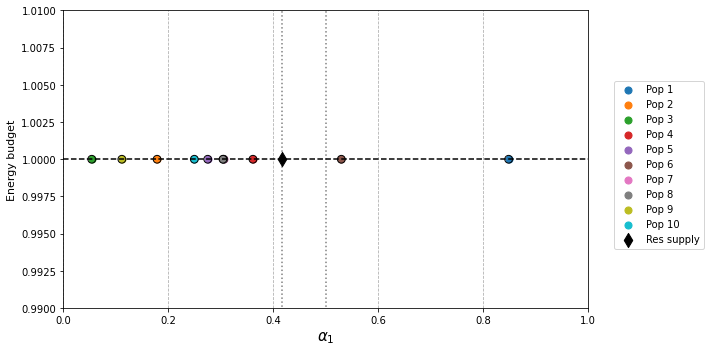

In [54]:
alpha_p = two_res_init(15,0)

In [55]:
n0_np=SupplyRateGen(n_pop,L)

for i, p in enumerate(n0_np):
    print("Pop %d initial abundance %.3f" %(i+1, p))

Pop 1 initial abundance 0.039
Pop 2 initial abundance 0.007
Pop 3 initial abundance 0.121
Pop 4 initial abundance 0.043
Pop 5 initial abundance 0.054
Pop 6 initial abundance 0.454
Pop 7 initial abundance 0.089
Pop 8 initial abundance 0.059
Pop 9 initial abundance 0.052
Pop 10 initial abundance 0.082


In [56]:
dt=2
n_iter=int(200000/dt)

n_p, time_spat = Simulation(n_iter_sim=n_iter,
                             dt_sim=dt,
                             n0_sim=n0_np,
                             n_res_sim=n_res_np,
                             alpha_sim=alpha_p,
                             S_sim=S_np,
                             D_sim=D,
                             delta_sim=1/n_res_np,
                             v_sim=1)

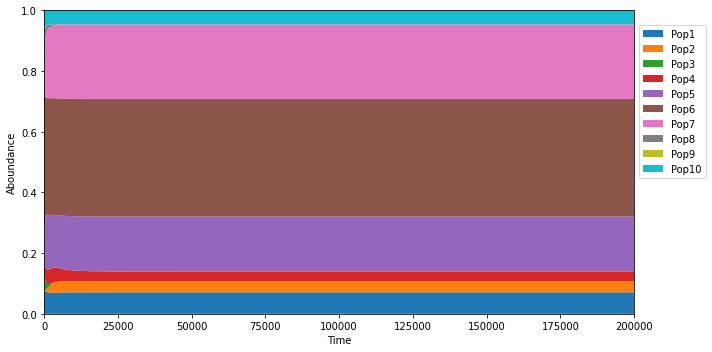

In [57]:
plot_fill(time_spat, n_p)

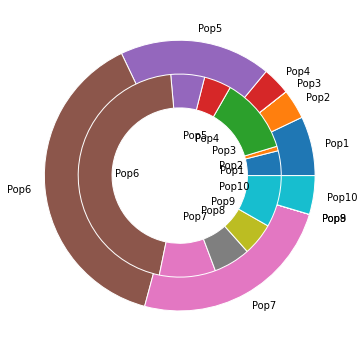

In [58]:
plot_pie(n_p)

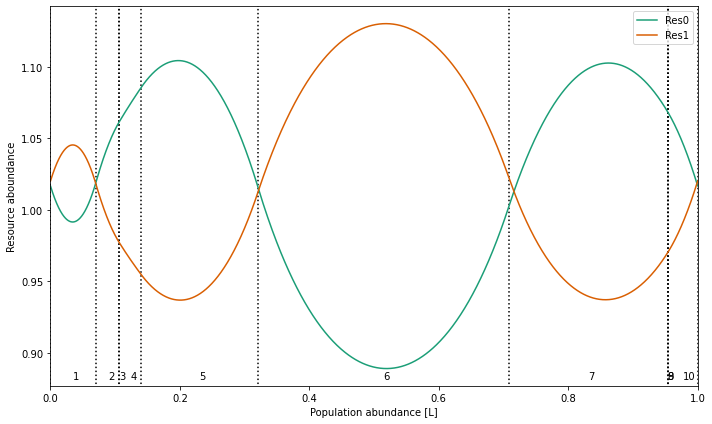

In [59]:
plot_RES(n_p, n_res_np, alpha_p, S_np, 0.01)

## Not perfect metabolic tradeoff

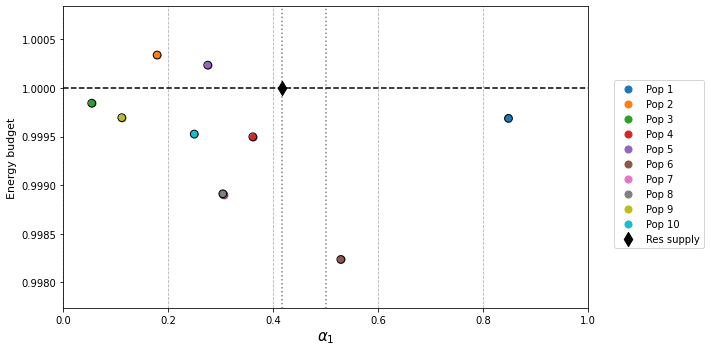

In [60]:
alpha_np = two_res_init(15, 1e-3)

In [61]:
dt=2
n_iter=int(200000/dt)

n_np, time_spat = Simulation(n_iter_sim=n_iter,
                             dt_sim=dt,
                             n0_sim=n0_np,
                             n_res_sim=n_res_np,
                             alpha_sim=alpha_np,
                             S_sim=S_np,
                             D_sim=D,
                             delta_sim=1/n_res_np,
                             v_sim=1)

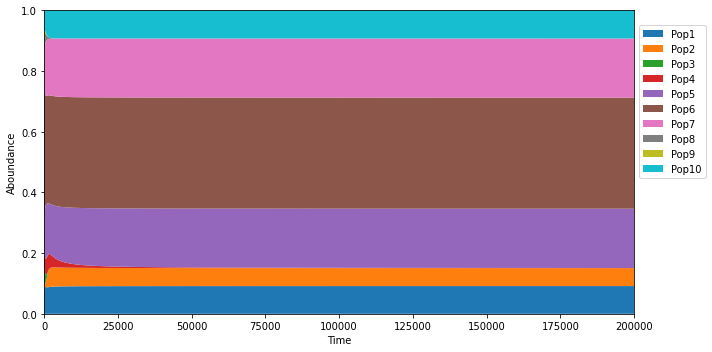

In [62]:
plot_fill(time_spat, n_np)

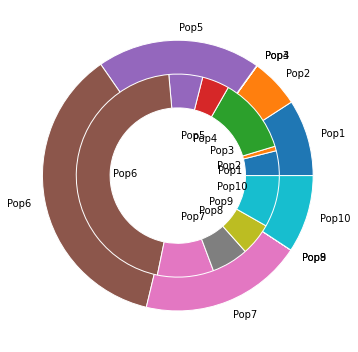

In [63]:
plot_pie(n_np)

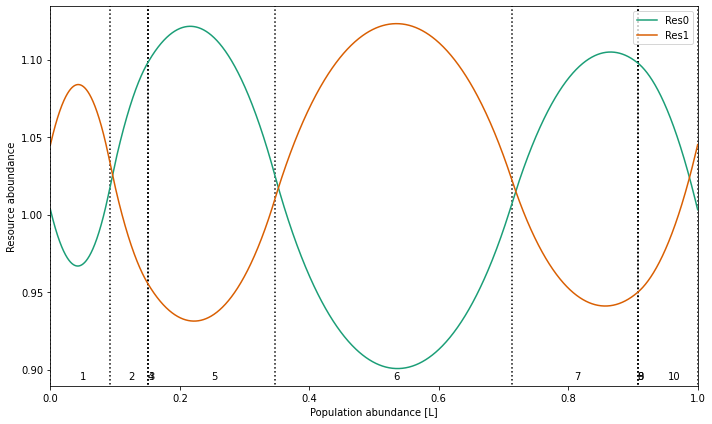

In [64]:
plot_RES(n_np, n_res_np, alpha_np, S_np, 0.01)

## Effective number of species comparison

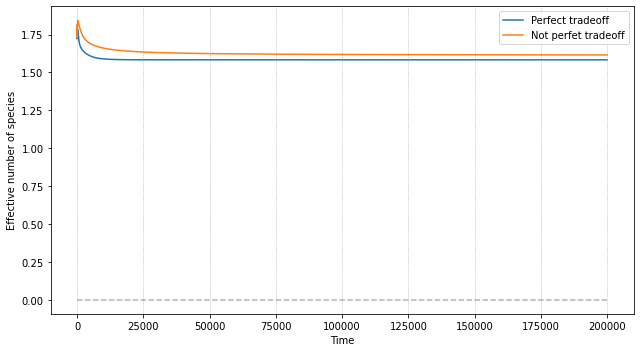

In [189]:
eff_ns_np = plot_M(n_np, show=False)
eff_ns_p = plot_M(n_p, show=False)

plt.figure(figsize=(9,5))
plt.plot(time_spat, eff_ns_p, label="Perfect tradeoff")
plt.plot(time_spat, eff_ns_np, label="Not perfet tradeoff")

plt.hlines(0,0,time_spat[-1], color="k", alpha=0.3, linestyles="--")
plt.grid(axis="x", linestyle=":")
plt.xlabel("Time")
plt.ylabel("Effective number of species")
plt.legend()
plt.tight_layout()
plt.show()


# Well mixed case 2 resources

In [114]:
dt_mix=1
duration_mix=200000
time_mix=np.arange(0,duration_mix+dt_mix,dt_mix)

## Pefcet metabolic tradeoff

In [81]:
n_mix = odeint(dtot, n0, time_mix, (alpha_p,1, S_np))

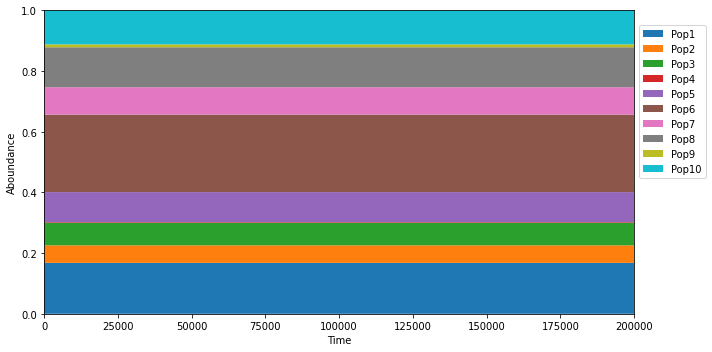

In [82]:
plot_fill(time_mix, n_mix, fix_bound=True)

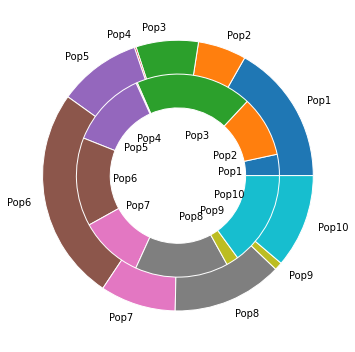

In [83]:
plot_pie(n_mix)

## Not perfect metabolic tradeoff

In [95]:
n_mix_np = odeint(dtot, n0, time_mix, (alpha_np,1, S_np))
n_mix_np[n_mix_np<0]=1e-10

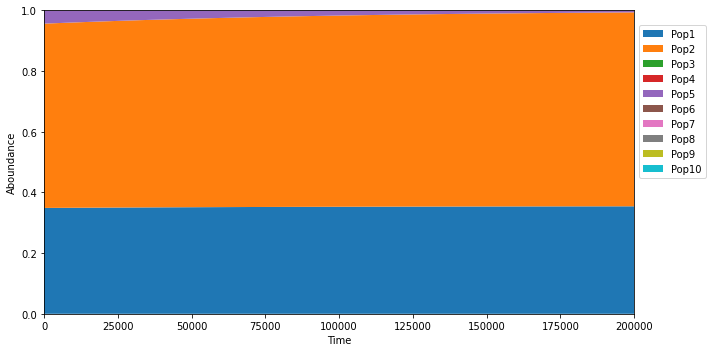

In [104]:
plot_fill(time_mix[:200001], n_mix_np[-200001:], fix_bound=True)

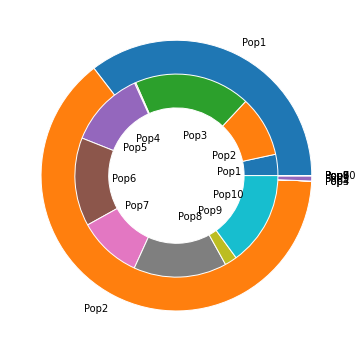

In [105]:
plot_pie(n_mix_np)

## Effective number of specied comparison

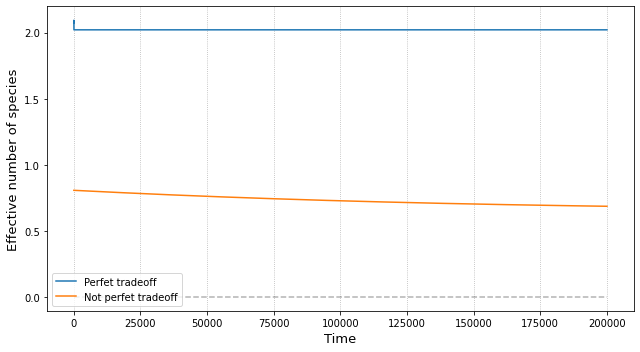

In [113]:
eff_mix_np = plot_M(n_mix_np, show=False)
eff_mix_p = plot_M(n_mix, show=False)

plt.figure(figsize=(9,5))
plt.plot(time_mix[:200001],eff_mix_p, label="Perfet tradeoff")
plt.plot(time_mix[:200000],eff_mix_np[-200000:], label="Not perfet tradeoff")

plt.hlines(0,0,time_mix[200000], color="k", alpha=0.3, linestyles="--")
plt.grid(axis="x", linestyle=":")
plt.xlabel("Time", fontsize=13)
plt.ylabel("Effective number of species", fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()


# Comparison between spatial and well mixed

## Presence of oligotrophs

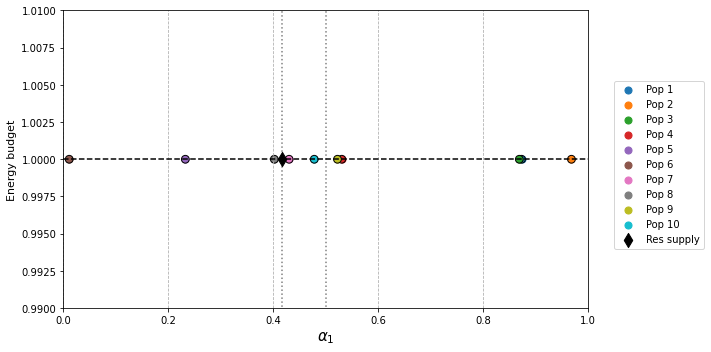

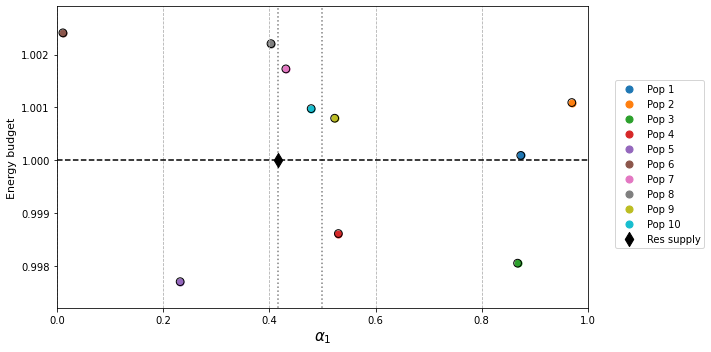

In [117]:
alpha_p_ol = two_res_init(8,0)
alpha_np_ol = two_res_init(8,1e-3)

In [118]:
dt=2
n_iter=int(200000/dt)



n_p_ol, time_spat_ol = Simulation(n_iter_sim=n_iter,
                             dt_sim=dt,
                             n0_sim=n0_np,
                             n_res_sim=n_res_np,
                             alpha_sim=alpha_p_ol,
                             S_sim=S_np,
                             D_sim=D,
                             delta_sim=1/n_res_np,
                             v_sim=1)

n_np_ol, time_spat_ol = Simulation(n_iter_sim=n_iter,
                             dt_sim=dt,
                             n0_sim=n0_np,
                             n_res_sim=n_res_np,
                             alpha_sim=alpha_np_ol,
                             S_sim=S_np,
                             D_sim=D,
                             delta_sim=1/n_res_np,
                             v_sim=1)

eff_ns_np_ol = plot_M(n_np_ol, show=False)
eff_ns_p_ol = plot_M(n_p_ol, show=False)

n_mix_np_ol = odeint(dtot, n0, time_mix, (alpha_np_ol,1, S_np))
n_mix_np_ol[n_mix_np_ol<0]=1e-10

n_mix_p_ol = odeint(dtot, n0, time_mix, (alpha_p_ol,1, S_np))
n_mix_p_ol[n_mix_p_ol<0]=1e-10

eff_mix_np_ol = plot_M(n_mix_np_ol, show=False)
eff_mix_p_ol = plot_M(n_mix_p_ol, show=False)


## Graphs

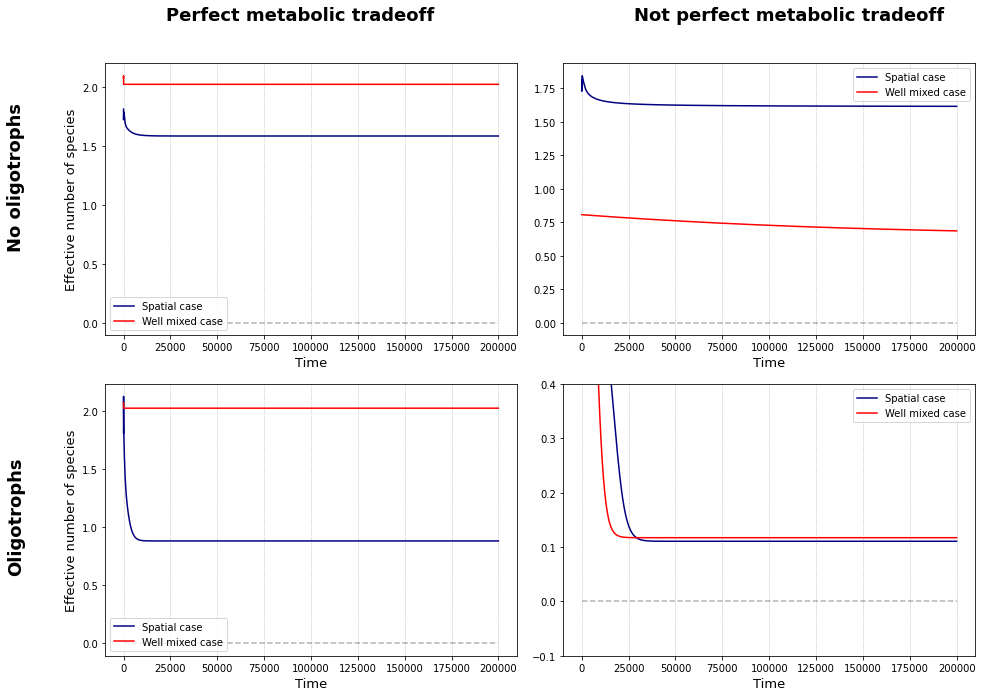

In [188]:
fig_comp, ax_comp = plt.subplots(2,2,figsize=(13,9))
ax_comp = ax_comp.flatten()

ax_comp[0].plot(time_spat,eff_ns_p, label="Spatial case", color="navy")
ax_comp[0].plot(time_mix,eff_mix_p, label="Well mixed case", color="red")

ax_comp[0].hlines(0,0,time_mix[-1], color="k", alpha=0.3, linestyles="--")
ax_comp[0].grid(axis="x", linestyle=":")
ax_comp[0].set_xlabel("Time", fontsize=13)
ax_comp[0].set_ylabel("Effective number of species", fontsize=13)
ax_comp[0].legend()
#ax_comp[0].set_title("Perfect metabolic tradeoff", fontweight="bold", fontsize=16)

ax_comp[1].plot(time_spat,eff_ns_np, label="Spatial case", color="navy")
ax_comp[1].plot(time_mix,eff_mix_np[-200001:], label="Well mixed case", color="red")

ax_comp[1].hlines(0,0,time_mix[-1], color="k", alpha=0.3, linestyles="--")
ax_comp[1].grid(axis="x", linestyle=":")
ax_comp[1].set_xlabel("Time", fontsize=13)
ax_comp[1].legend()
#ax_comp[1].set_title("Not perfect metabolic tradeoff", fontweight="bold", fontsize=16)


ax_comp[2].plot(time_spat,eff_ns_p_ol, label="Spatial case", color="navy")
ax_comp[2].plot(time_mix,eff_mix_p_ol, label="Well mixed case", color="red")

ax_comp[2].hlines(0,0,time_mix[-1], color="k", alpha=0.3, linestyles="--")
ax_comp[2].grid(axis="x", linestyle=":")
ax_comp[2].set_xlabel("Time", fontsize=13)
ax_comp[2].set_ylabel("Effective number of species", fontsize=13)
ax_comp[2].legend()
#ax_comp[2].set_title("Perfect metabolic tradeoff", fontweight="bold")

ax_comp[3].plot(time_spat,eff_ns_np_ol, label="Spatial case", color="navy")
ax_comp[3].plot(time_mix,eff_mix_np_ol, label="Well mixed case", color="red")

ax_comp[3].hlines(0,0,time_mix[-1], color="k", alpha=0.3, linestyles="--")
ax_comp[3].grid(axis="x", linestyle=":")
ax_comp[3].set_xlabel("Time", fontsize=13)
ax_comp[3].set_ylim([-0.1,0.4])
ax_comp[3].legend()
#ax_comp[3].set_title("Not perfect metabolic tradeoff", fontweight="bold")

#plt.suptitle("Not oligotrophs", fontweight="bold", fontsize=15)


fig_comp.text(0.12,1.05, "Perfect metabolic tradeoff", fontsize=18, fontweight="bold")
fig_comp.text(0.62,1.05, "Not perfect metabolic tradeoff", fontsize=18, fontweight="bold")
fig_comp.text(-0.05,0.7, "No oligotrophs", fontsize=18, fontweight="bold", rotation = "vertical")
fig_comp.text(-0.05,0.2, "Oligotrophs", fontsize=18, fontweight="bold", rotation = "vertical")
plt.tight_layout()
plt.show()

# Variation of dE

In [161]:
n_mult_fin=[]
n_mult_mix_fin=[]
alpha_fin=[]

dt=2
n_iter=int(10000/dt)
time_lengths=[10000]

S_mult=np.array([0.2,0.4,0.4])
n_res_mult=len(S_mult)

n_trials = 100
dE_list = [7e-2]

for j,de in enumerate(dE_list):
    E_mult=1
    n_mult_fin.append([])
    n_mult_mix_fin.append([])
    alpha_fin.append([])

    

    print(f"Trial dE with {de}")
    for k in tqdm(range(n_trials)):
        n0_np=SupplyRateGen(n_pop,L)
        alpha_mult=[]
        alpha_fin[j].append(alpha_mult)

        Energy_mult = np.random.normal(0, de, n_pop)+E_mult

        for i in range(n_pop):
            alpha_mult.append(SupplyRateGen(n_res_mult, Energy_mult[i]))
        
        n_mult, __ = Simulation(n_iter_sim=n_iter,
                                dt_sim=dt,
                                n0_sim=n0_np,
                                n_res_sim=n_res_mult,
                                alpha_sim=alpha_mult,
                                S_sim=S_mult,
                                D_sim=D,
                                delta_sim=1/n_res_mult,
                                v_sim=1)

        n_mult_mix = odeint(dtot, n0, np.arange(0,time_lengths[j],1), (alpha_mult,1, S_mult))

        n_mult_fin[j].append(n_mult[-1])
        n_mult_mix_fin[j].append(n_mult_mix[-1])
        

n_mult_fin=np.array(n_mult_fin)
n_mult_mix_fin=np.array(n_mult_mix_fin)
alpha_fin=np.array(alpha_fin)  

Trial dE with 0.07


100%|██████████| 100/100 [08:16<00:00,  4.97s/it]


In [122]:
M_fin=np.array([ [M(n_mult_fin[j,i,:]+1e-10) for i in range(n_trials)] for j in range(1) ])
M_mix_fin=np.array([ [M(n_mult_mix_fin[j,i,:]+1e-10) for i in range(n_trials)] for j in range(1) ])
print(M_fin.shape, M_mix_fin.shape)

(1, 100) (1, 100)


In [160]:
M_fin.mean()

8.454330697106398e-01

In [132]:
M_df_spat = pd.DataFrame( [ np.array([ [i]*n_trials for i in range(1)]).flatten() ,M_fin.flatten(), ["Spatial"]*1*n_trials ]).T
M_df_mix = pd.DataFrame( [ np.array([ [i]*n_trials for i in range(1)]).flatten() ,M_mix_fin.flatten(), ["Mixed"]*1*n_trials ]).T
M_df_mix.index=np.arange(1*n_trials,2*n_trials)
M_df = pd.concat([M_df_spat, M_df_mix])
M_df.columns=["dE", "n", "type"]
M_df

,dE,n,type
0,0,0.497422,Spatial
1,0,0.641639,Spatial
2,0,0.0,Spatial
3,0,0.294669,Spatial
4,0,1.180063,Spatial
...,...,...,...
195,0,0.609491,Mixed
196,0,0.709898,Mixed
197,0,0.319454,Mixed
198,0,0.698959,Mixed


In [136]:
M_df["dE"]=[4]*200
M_df_new=M_df

In [64]:
M_df.to_csv("M_df.csv")

In [152]:
M_df_old = pd.read_csv("M_df.csv", index_col=0)

In [154]:
M_df_old.shape

(1000, 3)

In [155]:
M_df = pd.concat([M_df_old[M_df_old["dE"]!=4],M_df_new])

In [157]:
M_df.index=np.arange(1000)

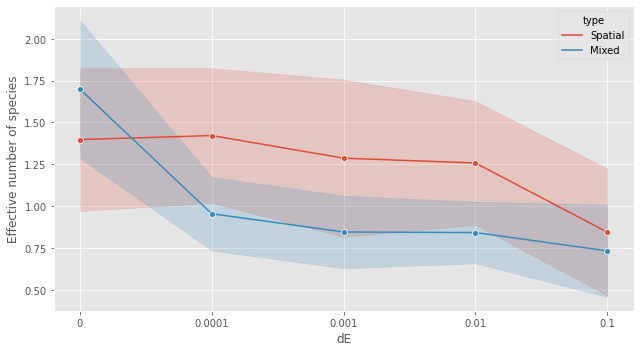

In [158]:
plt.figure(figsize=(9,5))
with plt.style.context("ggplot"):
    M_seab = sns.lineplot(data=M_df, x="dE", y="n", hue="type", ci="sd", marker="o")
    M_seab.set_xticks(np.arange(5))
    M_seab.set_xticklabels([0, 1e-4, 1e-3, 1e-2, 1e-1])
    M_seab.set_xlabel("dE")
    M_seab.set_ylabel("Effective number of species")
plt.tight_layout()

In [66]:
n_species_dE = [[len(nsh[nsh>1e-2]) for nsh in n_spat_hist] for n_spat_hist in n_mult_fin]
edges=np.arange(n_pop+2)-0.5

p_dE = figure(plot_width=800, plot_height=400,
             x_axis_label='Number of not extincted species',
             x_axis_location='below',
             y_axis_label='Frequency',
             y_axis_location='left',
             y_axis_type='linear',
             )


for j, dE in enumerate(dE_list):
        u=np.unique(n_species_dE[j], return_counts=True)
        a=np.zeros(n_pop+1)
        a[u[0]]=u[1]

        p_dE.quad(top=a, bottom=0, left=edges[:-1], right=edges[1:],
                fill_color=Category10[len(dE_list)][j], line_color="white", alpha=0.5, legend_label="dE="+str(dE))

p_dE.legend.location = "top_left"
p_dE.legend.click_policy="hide"
show(p_dE)

In [67]:
n_species_dE_mix = [[len(nsh[nsh>1e-2]) for nsh in n_spat_hist] for n_spat_hist in n_mult_mix_fin]
edges=np.arange(n_pop+2)-0.5

p_dE_mix = figure(plot_width=800, plot_height=400,
             x_axis_label='Number of not extincted species',
             x_axis_location='below',
             y_axis_label='Frequency',
             y_axis_location='left',
             y_axis_type='linear',
             )


for j, dE in enumerate(dE_list):
        u=np.unique(n_species_dE_mix[j], return_counts=True)
        a=np.zeros(n_pop+1)
        a[u[0]]=u[1]

        p_dE_mix.quad(top=a, bottom=0, left=edges[:-1], right=edges[1:],
                fill_color=Category10[len(dE_list)][j], line_color="white", alpha=0.5, legend_label="dE="+str(dE))

p_dE_mix.legend.location = "top_left"
p_dE_mix.legend.click_policy="hide"
show(p_dE_mix)

# Oligotroph

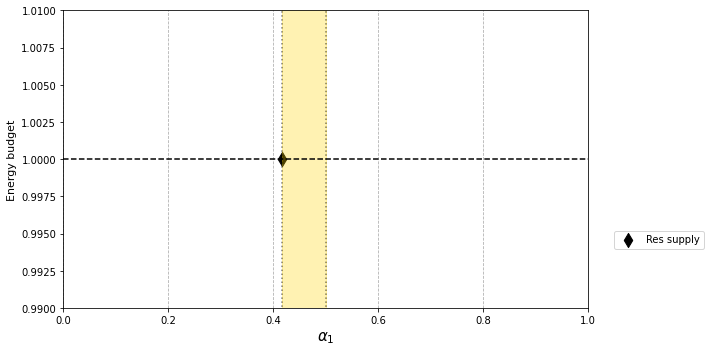

In [68]:
import matplotlib.patches as patches

alpha_p=[]

Energy_np = np.random.normal(0, 0, n_pop)+E_np

np.random.seed(3)
for i in range(n_pop):
    alpha_p.append(SupplyRateGen(n_res_np, Energy_np[i]))

__, ax_rect = plt.subplots(1,1,figsize=(10,5))


ax_rect.hlines(1,0,1,linestyles="--", colors="k")
ax_rect.vlines(0.5,-10,10, linestyle=":", alpha=0.5, color="k")
ax_rect.vlines(S_np[0],-10,10, linestyle=":", alpha=0.5, color="k")
rect = patches.Rectangle([S_np[0],0.5],0.5-S_np[0],2, alpha=0.3, color="gold")
ax_rect.add_patch(rect)

ax_rect.scatter(S_np[0], E_np, s=100, marker="d", color="k", label="Res supply")

ax_rect.set_ylim([0.99,1.01])
ax_rect.set_xlim([0,1])
ax_rect.set_xlabel(r"$\alpha_{1}$", fontsize=15)
ax_rect.set_ylabel("Energy budget", fontsize=11)

ax_rect.legend(loc=(1.05,0.2))
ax_rect.grid(axis="x", linestyle="--")
plt.tight_layout()

In [374]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Slider, CustomJS
from bokeh.plotting import figure, output_file, show, save
from bokeh.models.annotations import Span, Arrow
import numpy as np

x = np.linspace(0, 1, 500)
y_1 = 1-x
y_2 = 0.4*x/(2*x-0.6)
source = ColumnDataSource(data=dict(x=x, y_1=y_1, y_2=y_2))

# Create plots and widgets
plot = figure(x_range=(0,1), y_range=(0,1), width=500, height=300)
fig = figure(x_range=(0,1), y_range=(0.99,1.01), width=500, height=350)

plot.line('x', 'y_1', source=source, line_width=3, line_alpha=0.5)
plot.line('x', 'y_2', source=source, line_width=3, line_alpha=0.5, color="red")

# Create Slider object
slider = Slider(start=0, end=1, value=0.4,
				step=0.01, title='S')

span = Span(location=slider.value, dimension='height', line_width=3)
span_fix = Span(location=0.5, dimension="height", line_width=3)

fig.add_layout(span)
fig.add_layout(span_fix)
fig.line(np.linspace(-10,10,100), 1, line_dash="dashed", color="black")

# Adding callback code
callback = CustomJS(args=dict(source=source, val=slider, span=span),
					code="""
	const data = source.data;

	const S = val.value;
	const x = data['x'];
	const y_2 = data['y_2'];
	span.location = S;
for (var i = 0; i < x.length; i++) {
		y_2[i] = (1-S)*x[i]/(2*x[i]-S);
	}
	
	source.change.emit();
""")

slider.js_on_change('value', callback)

# Arrange plots and widgets in layouts
layout = row(fig, column(slider, plot))

show(layout)
output_file(filename="olig.html",mode="cdn")
save(layout)

'/home/francesco/Documenti/GitHub/QLS_2021_2022/Project/olig.html'

In [120]:
np.random.seed(2)
Energy_ol=5
alpha_total=[]

for i in range(5000):
    alpha_total.append(SupplyRateGen(n_res, Energy_ol))

alpha_total=np.array(alpha_total)

In [121]:
alpha_total.shape
alpha_tot_df=pd.DataFrame({"Res1": alpha_total[:,0],"Res2": alpha_total[:,1],"Res3": alpha_total[:,2]})

alpha_tot_df["Olig."]= S[0]/alpha_tot_df["Res1"]+S[1]/alpha_tot_df["Res2"]+S[2]/alpha_tot_df["Res3"]<3/5
alpha_tot_df

,Res1,Res2,Res3,Olig.
0,0.129631,2.050343,2.820025,False
1,2.176612,0.571700,2.251688,False
2,1.651674,0.450165,2.898161,False
3,1.023243,2.073112,1.903645,True
4,1.334136,0.164137,3.501727,False
...,...,...,...,...
4995,1.115669,2.155472,1.728859,True
4996,3.580333,0.839933,0.579734,False
4997,1.232720,2.593196,1.174084,False
4998,1.098580,2.572300,1.329119,False


In [122]:
triang_olig = px.scatter_ternary(alpha_tot_df, a="Res1", b="Res2", c="Res3", color="Olig.", width=750, labels={"Olig.":"Oligotroph"})

triang_olig.add_scatterternary(a=[S[0]], b=[S[1]], c=[S[2]], mode='markers', marker_symbol='star', marker_color='black', marker_size=10, name="Supply rate")

In [123]:
alpha_ol, alpha_norm = [], []


for i in range(len(alpha_total)):
    if sum([S[j]/alpha_total[i][j] for j in range(n_res)])<3/5:
        o_col="red"
        alpha_ol.append(alpha_total[i])
    else:
        o_col="blue"
        alpha_norm.append(alpha_total[i])

alpha_ordered = np.concatenate([alpha_ol, alpha_norm])

print("Number of possible alphas: %d" %(alpha_ordered.shape[0]))
print("Oligotroph region: %d-%d" %(0, len(alpha_ol)))
print("Not oligotroph region: %d-%d" %(len(alpha_ol)+1, alpha_ordered.shape[0]))


Number of possible alphas: 5000
Oligotroph region: 0-124
Not oligotroph region: 125-5000


In [124]:
dt=2
n_iter=int(3000/dt)

M_bool= []
index_bool=[]
boll_ol=[]

for i in tqdm(range(5000)):
    try:
        index_alpha = np.random.randint(0,5000,10)
        
        
        n_bool, time_bool = Simulation(n_iter_sim=n_iter,
                            dt_sim=dt,
                            n0_sim=n0,
                            n_res_sim=n_res,
                            alpha_sim=alpha_ordered[index_alpha],
                            S_sim=S,
                            D_sim=D,
                            delta_sim=1/n_res,
                            v_sim=1)

        index_bool.append(index_alpha)
        boll_ol.append(len(np.where(index_alpha<124)[0]))
        M_bool.append(plot_M(n_bool, False)[-1])
    except:
        pass
boll_ol = np.array(boll_ol)
M_bool=np.array(M_bool)

100%|██████████| 5000/5000 [2:20:08<00:00,  1.68s/it]  


In [127]:
print(*M_bool.shape)
print(*boll_ol.shape)

4990
4990


In [128]:
alpha_df = pd.DataFrame(alpha_ordered)
alpha_df

,0,1,2
0,1.023243,2.073112,1.903645
1,1.452134,1.646074,1.901793
2,1.416294,1.893545,1.690161
3,1.297402,2.164594,1.538004
4,1.327217,1.536844,2.135939
...,...,...,...
4995,0.809373,1.062086,3.128541
4996,3.580333,0.839933,0.579734
4997,1.232720,2.593196,1.174084
4998,1.098580,2.572300,1.329119


In [157]:
np.array(index_bool)

array([[4022, 4322, 4966, ..., 4989, 3288, 1813],
       [2999,  560, 1267, ..., 4247, 4645, 2760],
       [4005, 2412, 4977, ..., 3891,  925, 4189],
       ...,
       [1267, 1329,  570, ..., 2558, 2939,  361],
       [1473, 2857,  988, ..., 3805,  855, 4015],
       [1556,  251, 1844, ...,  240, 1724, 2690]])

In [172]:
M_ol = pd.DataFrame( [M_bool,boll_ol]).T
#M_ol1.columns=["M", "bool"]
M_ol_index = pd.DataFrame(np.array(index_bool))

M_ol

,0,1
0,1.252877,0.0
1,1.277165,0.0
2,1.826690,0.0
3,0.836164,0.0
4,1.436003,0.0
...,...,...
4985,0.923322,0.0
4986,1.045043,0.0
4987,0.886904,1.0
4988,1.414264,0.0


In [173]:
M_ol_index.to_csv("M_ol_index.csv")
M_ol.to_csv("M_ol.csv")

In [180]:
M_ol = pd.read_csv("M_ol.csv", index_col=0)
M_ol_index = pd.read_csv("M_ol_index.csv", index_col=0)
index_bool = M_ol_index.to_numpy()
M_bool = M_ol.to_numpy()[:,0]
boll_ol = M_ol.to_numpy()[:,1]


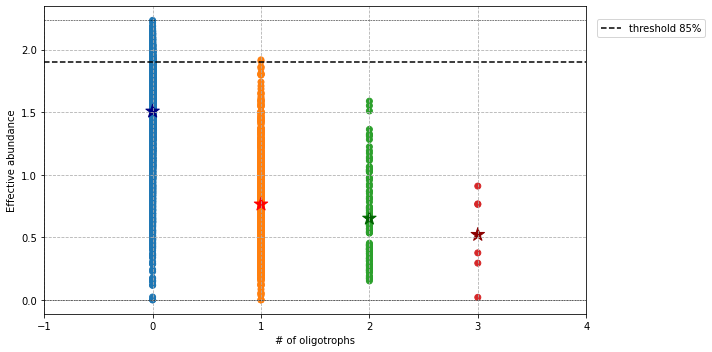

In [275]:
threshold = (np.nanmax(M_bool)-np.nanmin(M_bool))*0.85+np.nanmin(M_bool)

plt.figure(figsize=(10,5))

plt.scatter(boll_ol, M_bool, marker="o", color=["C"+str(int(b)) for b in boll_ol])
star_color = ["navy", "red", "darkgreen", "darkred", "mediumorchid", "chocolate"]
plt.scatter(np.unique(boll_ol), [np.nanmean(M_bool[np.array(boll_ol)==b_u]) for b_u in np.unique(boll_ol)], marker="*", s=200, color=star_color[:len(np.unique(boll_ol))])
plt.hlines(np.nanmax(M_bool), -1,max(boll_ol)+1, color="k", linestyle="--", lw=0.5)
plt.hlines(np.nanmin(M_bool), -1,max(boll_ol)+1, color="k", linestyle="--", lw=0.5)
plt.hlines(threshold, -1,max(boll_ol)+1, color="k", linestyle="--", label="threshold 85%")

plt.ylabel("Effective abundance")
plt.xlabel("# of oligotrophs")
plt.legend(loc=[1.02, 0.9])
plt.grid(linestyle="--")
plt.xlim([-1,max(boll_ol)+1])
plt.tight_layout()

In [273]:
max_indexes = np.array(index_bool)[M_bool>threshold]
alpha_res_ol = np.array([alpha_ordered[mi] for mi in max_indexes]).flatten()

alpha_res_ol_df=pd.DataFrame({"Res1": alpha_total[:,0],"Res2": alpha_total[:,1],"Res3": alpha_total[:,2]})

alpha_res_ol_df["Olig."]= S[0]/alpha_res_ol_df["Res1"]+S[1]/alpha_res_ol_df["Res2"]+S[2]/alpha_res_ol_df["Res3"]<3/5
alpha_res_ol_df
#alpha_res_ol_df.to_csv("alpha_res_ol.csv")

,Res1,Res2,Res3,Olig.
0,0.129631,2.050343,2.820025,False
1,2.176612,0.571700,2.251688,False
2,1.651674,0.450165,2.898161,False
3,1.023243,2.073112,1.903645,True
4,1.334136,0.164137,3.501727,False
...,...,...,...,...
4995,1.115669,2.155472,1.728859,True
4996,3.580333,0.839933,0.579734,False
4997,1.232720,2.593196,1.174084,False
4998,1.098580,2.572300,1.329119,False


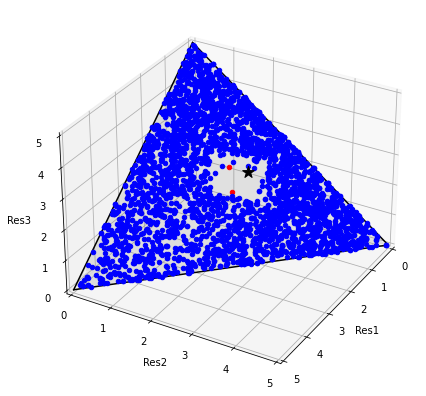

In [276]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection="3d")

max_indexes = np.array(index_bool)[M_bool>threshold]

for i in range(len(max_indexes)):
    for alpha_now in alpha_ordered[max_indexes[i]]:
        if sum([S[j]/alpha_now[j] for j in range(n_res)])<3/5:
            o_col="red"
        else:
            o_col="blue"
        
        ax.scatter3D(alpha_now[0],alpha_now[1],alpha_now[2], color=o_col) #metabolic strategie points

plot_triangle(ax, Energy_ol)

ax.scatter(Energy_ol/S_tot*S[0],Energy_ol/S_tot*S[1],Energy_ol/S_tot*S[2], color="k", marker="*", s=150) #Point defined by the supply rate

ax.azim=30 #change the orientation of the graph

ax.set_xlim(0,Energy_ol)
ax.set_ylim(0,Energy_ol)
ax.set_zlim(0,Energy_ol)
ax.set_xlabel("Res1")
ax.set_ylabel("Res2")
ax.set_zlabel("Res3")

plt.show()

# Proposals

Si potrebbe aumentare il numero di risorse e vedere come varia il numero di specie effettivo. In teoria più è alta la dimensione più dovrebbe essere raro trovare un oligotropo, dunque dovrebbe in teoria esserci più diversità.

In [19]:
n_res_list=np.arange(2,7)

dt=2
n_iter=int(3000/dt)

alpha_aug_list = []
S_aug_list = []
n_aug_list = []

for k, n_res_aug in enumerate(n_res_list):
    print(f"Number of resources = {n_res_aug}")
    alpha_aug_list.append([])
    S_aug_list.append([])
    n_aug_list.append([])
    for i in tqdm(range(500)):
        try:
            alpha_aug=[]
            for i in range(n_pop):
                alpha_aug.append(SupplyRateGen(n_res_aug, Energy))
            
            S_aug = SupplyRateGen(n_res_aug, 1)
            
            n_aug, __ = Simulation(n_iter_sim=n_iter,
                                dt_sim=dt,
                                n0_sim=n0,
                                n_res_sim=n_res_aug,
                                alpha_sim=alpha_aug,
                                S_sim=S_aug,
                                D_sim=D,
                                delta_sim=1/n_res_aug,
                                v_sim=1)
            alpha_aug_list[-1].append(alpha_aug)
            S_aug_list[-1].append(S_aug)
            n_aug_list[-1].append(n_aug[-1])
        except:
            pass

Number of resources = 2


100%|██████████| 500/500 [07:28<00:00,  1.11it/s]


Number of resources = 3


100%|██████████| 500/500 [10:09<00:00,  1.22s/it]


Number of resources = 4


100%|██████████| 500/500 [13:16<00:00,  1.59s/it]


Number of resources = 5


100%|██████████| 500/500 [15:27<00:00,  1.85s/it]


Number of resources = 6


100%|██████████| 500/500 [18:06<00:00,  2.17s/it]


In [255]:
n_species_aug = [[len(nsh[nsh>1e-2]) for nsh in n_spat_hist] for n_spat_hist in n_aug_list]
edges=np.arange(n_pop+2)-0.5

p_aug = figure(plot_width=800, plot_height=400,
             x_axis_label='Number of not extincted species',
             x_axis_location='below',
             y_axis_label='Frequency',
             y_axis_location='left',
             y_axis_type='linear',
             )


for j, dE in enumerate(n_res_list):
        u=np.unique(n_species_aug[j], return_counts=True)
        a=np.zeros(n_pop+1)
        a[u[0]]=u[1]

        p_aug.quad(top=a, bottom=0, left=edges[:-1], right=edges[1:],
                fill_color=Bokeh[len(n_res_list)][j], line_color="white", alpha=0.5, legend_label="#res="+str(dE))

p_aug.legend.location = "top_left"
p_aug.legend.click_policy="hide"
show(p_aug)

In [48]:
M_aug = np.array([[M(mdv1) for mdv1 in mdv0] for mdv0 in n_aug_list])

aug_df = pd.DataFrame((np.array([[di]*500 for di in n_res_list]).flatten(), np.concatenate(M_aug))).T
aug_df.columns=["n spec", "n"]
aug_df.head()

,n spec,n
0,2.0,0.656329
1,2.0,NaN
2,2.0,0.347539
3,2.0,1.410319
4,2.0,0.639507


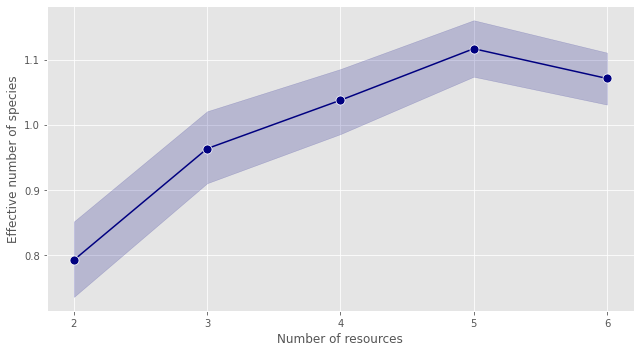

In [120]:
plt.figure(figsize=(9,5))
with plt.style.context("ggplot"):
    aug_seab = sns.lineplot(data=aug_df, x="n spec", y="n", color="navy", marker="o", markersize=9, ci="sd")
    aug_seab.set_xlabel("Number of resources")
    aug_seab.set_ylabel("Effective number of species")
    aug_seab.set_xticks(n_res_list)
plt.tight_layout()

Per quanto riguarda la stocasticità nelle popolzaioni, si potrebbe fare aggiungendo delle quantità che sommano a 0, penso che non dovrebbero influire sulla stabilità delle popolazioni. Infatti se il death rate è impostato giusto, la somma delle popolazione rimane sempre uguale al valore iniziale, dunque se ad un certo punto immettiamo o togliamo un po' di individui, la popolazione totale cambia ma dovrebbe rimanere uguale fino a che non viene perturbata di nuovo

Esplorare la struttura degli oligotropi

In [166]:
def Simulation_stochastic(n_iter_sim, dt_sim, n0_sim, n_res_sim, alpha_sim, S_sim, D_sim ,delta_sim, v_sim=1, strenght=0.001):
    n_sim=[]
    n_sim.append(n0_sim)

    n_pop_sim=len(n0_sim)
    time_sim=np.arange(0,n_iter_sim*dt_sim+dt_sim,dt_sim)

    for t in range(n_iter_sim):
        sol_all_sim=[]
        for j in range(n_res_sim):
            sol, coeff_matr, const_matr = ResParams(n_sim[t], j, alpha_sim, S_sim,D_sim)
            sol_all_sim.append(sol)
        n_stoch = np.random.normal(0, strenght, n_pop-1)
        n_stoch = np.append(n_stoch, -np.sum(n_stoch))
        np.random.shuffle(n_stoch)
        n_now=[]
        res=0
        for p in range(n_pop):
            curr_incr = n_sim[t][p]+n_stoch[p]+n_incr(p,n_sim[t],alpha_sim,S_sim,sol_all_sim,delta_sim,v_sim,D_sim)*dt_sim
            if curr_incr<0:
                res += curr_incr
                curr_incr = 0
            else:
                curr_incr += res
                res = 0
            n_now.append(curr_incr)
        n_now[np.argmax(n_now)]+=res
        n_sim.append(n_now)
    return np.array(n_sim), time_sim

In [184]:
dt=1
n_iter=int(10000/dt)

n, time = Simulation_stochastic(n_iter_sim=n_iter,
                     dt_sim=dt,
                     n0_sim=n0,
                     n_res_sim=n_res,
                     alpha_sim=alpha,
                     S_sim=S,
                     D_sim=1,
                     delta_sim=1/n_res,
                     v_sim=1,
                     strenght=0.001)

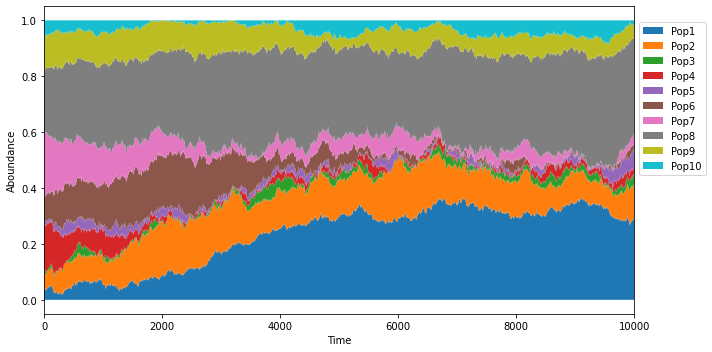

In [185]:
plot_fill(time, n, fix_bound=False)

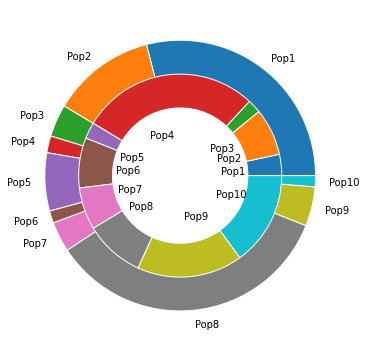

In [186]:
plot_pie(n)

# Cose da ricordarsi

1. dinamica molto sensibile a variazioni anche molto piccole del death rate che portano alla divergenza del numero totale di individui.
2. difficile studiare proprietà generali del modello spaziale a causa degli oligotropi
3. magari sui vari aggiustamenti per fare un modello stocastico
4. 